## **Importing Libraries**

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [40]:
from fastai.vision import *
from fastai.metrics import error_rate

# **Stage 1**

## **Data Setup and Preview**

In [52]:
data_path = Path.home()/'notebooks/programming/data/watch_bot'
csv_path_1 = Path.home()/'notebooks/programming/projects/watch_bot/data_prep/file_attribs_watch_bot.csv'
csv_path_2 = Path.home()/'notebooks/programming/projects/watch_bot/data_prep/chrono24_dial_visibility_most_uncertain.csv'


In [53]:
df1 = pd.read_csv(csv_path_1)
df1.head()

,image_size_x,image_size_y,name,dial_visibility,like,image_quality
0,960,960,nomos_1/nomos/_without_model/nomos_@_the_loupe...,1.0,1.0,1.0
1,960,960,nomos_1/nomos/_without_model/nomos_@_the_loupe...,1.0,0.0,1.0
2,960,960,nomos_1/nomos/_without_model/nomos_@_the_loupe...,0.0,0.0,0.0
3,720,960,nomos_1/nomos/_without_model/nomos_beta_11156_...,1.0,0.0,1.0
4,720,960,nomos_1/nomos/_without_model/nomos_beta_11156_...,1.0,0.0,1.0


In [54]:
df1.shape

(11973, 6)

In [55]:
df2 = pd.read_csv(csv_path_2)
df2.head()

,image_size_x,image_size_y,name,dial_visibility,dial_visibility_p_0,dial_visibility_p_1,like,like_p_0,like_p_1,image_quality
0,640,480,chrono24_dial_visibility_most_uncertain/a._lan...,1.0,0.473409,0.526591,-1.0,-1,-1,-1.0
1,1200,718,chrono24_dial_visibility_most_uncertain/a._lan...,0.0,0.480346,0.519654,-1.0,-1,-1,-1.0
2,640,480,chrono24_dial_visibility_most_uncertain/a._lan...,0.0,0.471942,0.528058,-1.0,-1,-1,-1.0
3,640,480,chrono24_dial_visibility_most_uncertain/a._lan...,0.0,0.477966,0.522034,-1.0,-1,-1,-1.0
4,640,480,chrono24_dial_visibility_most_uncertain/a._lan...,0.0,0.471942,0.528058,-1.0,-1,-1,-1.0


In [56]:
df2.shape

(17142, 10)

In [69]:
df = pd.concat([df1, df2], ignore_index=True)
df = df.dropna(axis=1, how='any')
df

,image_size_x,image_size_y,name,dial_visibility,like,image_quality
0,960,960,nomos_1/nomos/_without_model/nomos_@_the_loupe...,1.0,1.0,1.0
1,960,960,nomos_1/nomos/_without_model/nomos_@_the_loupe...,1.0,0.0,1.0
2,960,960,nomos_1/nomos/_without_model/nomos_@_the_loupe...,0.0,0.0,0.0
3,720,960,nomos_1/nomos/_without_model/nomos_beta_11156_...,1.0,0.0,1.0
4,720,960,nomos_1/nomos/_without_model/nomos_beta_11156_...,1.0,0.0,1.0
...,...,...,...,...,...,...
29110,960,960,chrono24_dial_visibility_most_uncertain/zenith...,1.0,-1.0,-1.0
29111,960,960,chrono24_dial_visibility_most_uncertain/zenith...,1.0,-1.0,-1.0
29112,767,960,chrono24_dial_visibility_most_uncertain/zenith...,0.0,-1.0,-1.0
29113,720,960,chrono24_dial_visibility_most_uncertain/zenith...,0.0,-1.0,-1.0


In [74]:
df = df[['name', 'dial_visibility']]
df = df.astype({'dial_visibility':'int'})
df.dtypes

name               object
dial_visibility     int64
dtype: object

In [91]:
bs = 64
image_size = 128
xform = get_transforms(flip_vert=True, max_lighting=0.4, max_warp=0.1)

In [92]:
src = (ImageList.from_df(df, data_path)
        .split_by_rand_pct()
        .label_from_df())

In [93]:
data = (src.transform(tfms=xform, size=image_size)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [94]:
data

ImageDataBunch;

Train: LabelList (23292 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
1,1,1,0,0
Path: /home/neronicolo/notebooks/programming/data/watch_bot;

Valid: LabelList (5823 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
1,0,1,0,0
Path: /home/neronicolo/notebooks/programming/data/watch_bot;

Test: None

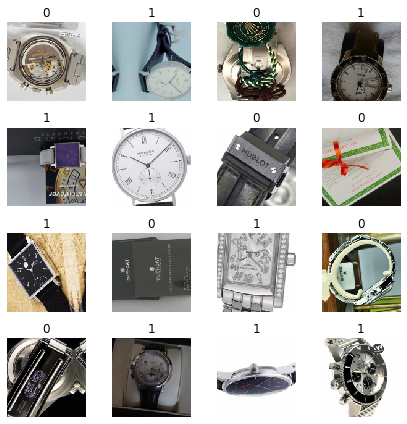

In [95]:
data.show_batch(rows=4, figsize=(6,6))

## **Training**

In [96]:
learn = create_cnn(data, models.resnet50, metrics=[accuracy])
learn = learn.to_fp16()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


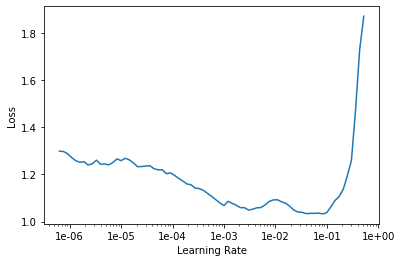

In [97]:
learn.lr_find()
learn.recorder.plot()

In [100]:
learn.fit_one_cycle(5, slice(5e-04))

epoch,train_loss,valid_loss,accuracy,time
0,0.204045,0.188047,0.921518,02:42
1,0.193953,0.185810,0.924438,02:42
2,0.195126,0.182122,0.926155,02:41
3,0.204512,0.181023,0.924781,02:46
4,0.187247,0.180407,0.924953,02:43
